# Regression models for streets with traffic volume measurements

This notebook includes a few regression models built upon the subset of streets in our dataset that include traffic volume measurements. This significantly reduces the number of observations in the dataset, but in turn seems to produce models with a higher predictive power. Indeed, the average traffic volume of a street appears to be a significant contributing factor to the weekly collision rate of that street (as it would be expected).

In [57]:
import matplotlib.pyplot as plt

plt.style.use("customstyle.mplstyle")

In [58]:
import pandas as pd
from pathlib import Path

DATA_FOLDER = Path("../data")

collisions = pd.read_pickle(DATA_FOLDER / "final_dataset_train.pkl")

In [59]:
collisions.columns

Index(['physicalid', 'geometry', 'has_bike_lane', 'st_width', 'shape_leng',
       'is_av', 'is_st', 'is_rd', 'has_humps', 'collision_rate', 'n_trees',
       'speed_limit', 'traffic_volume', 'n_parking_meters',
       'collision_rate_per_length', 'has_volume_meas', 'has_parking_meters'],
      dtype='object')

In [60]:
collisions_train = collisions[collisions["has_volume_meas"]].drop(
    columns=["physicalid", "geometry", "has_parking_meters"]
)

In [61]:
import numpy as np

collisions_train_extra = collisions_train.copy()

# Pipeline
collisions_train_extra["log_leng"] = np.log1p(collisions_train_extra["shape_leng"])
collisions_train_extra["log_width"] = np.log1p(collisions_train_extra["st_width"])
collisions_train_extra["inv_trees"] = 1.0 / (1 + collisions_train_extra["n_trees"])
collisions_train_extra["leng_per_tree"] = collisions_train_extra["log_leng"] / (
    1 + collisions_train_extra["n_trees"]
)
collisions_train_extra["width_per_tree"] = collisions_train_extra["log_width"] / (
    1 + collisions_train_extra["n_trees"]
)
collisions_train_extra["log_traffic_volume"] = np.log1p(
    collisions_train_extra["traffic_volume"]
)

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin

st_width_ix, st_leng_ix, trees_ix, speed_lim_ix, traffic_vol_ix = list(
    map(
        collisions_train.columns.get_loc,
        ["st_width", "shape_leng", "n_trees", "speed_limit", "traffic_volume"],
    )
)


class LogarithmTransfomer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.get_feature_names_in_ = X.columns.to_numpy()
        return self

    def transform(self, X):
        return np.log1p(X)

    def get_feature_names_out(self, input_features):
        return np.apply_along_axis(lambda o: "log_" + o, 0, input_features)


class InverseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.get_feature_names_in_ = X.columns.to_numpy()
        return self

    def transform(self, X):
        return 1 / (1 + X)

    def get_feature_names_out(self, input_features):
        return np.apply_along_axis(lambda o: "inv_" + o, 0, input_features)

In [63]:
np.apply_along_axis(lambda o: "log_" + o, 0, collisions_train.columns.to_numpy())

array(['log_has_bike_lane', 'log_st_width', 'log_shape_leng', 'log_is_av',
       'log_is_st', 'log_is_rd', 'log_has_humps', 'log_collision_rate',
       'log_n_trees', 'log_speed_limit', 'log_traffic_volume',
       'log_n_parking_meters', 'log_collision_rate_per_length',
       'log_has_volume_meas'], dtype=object)

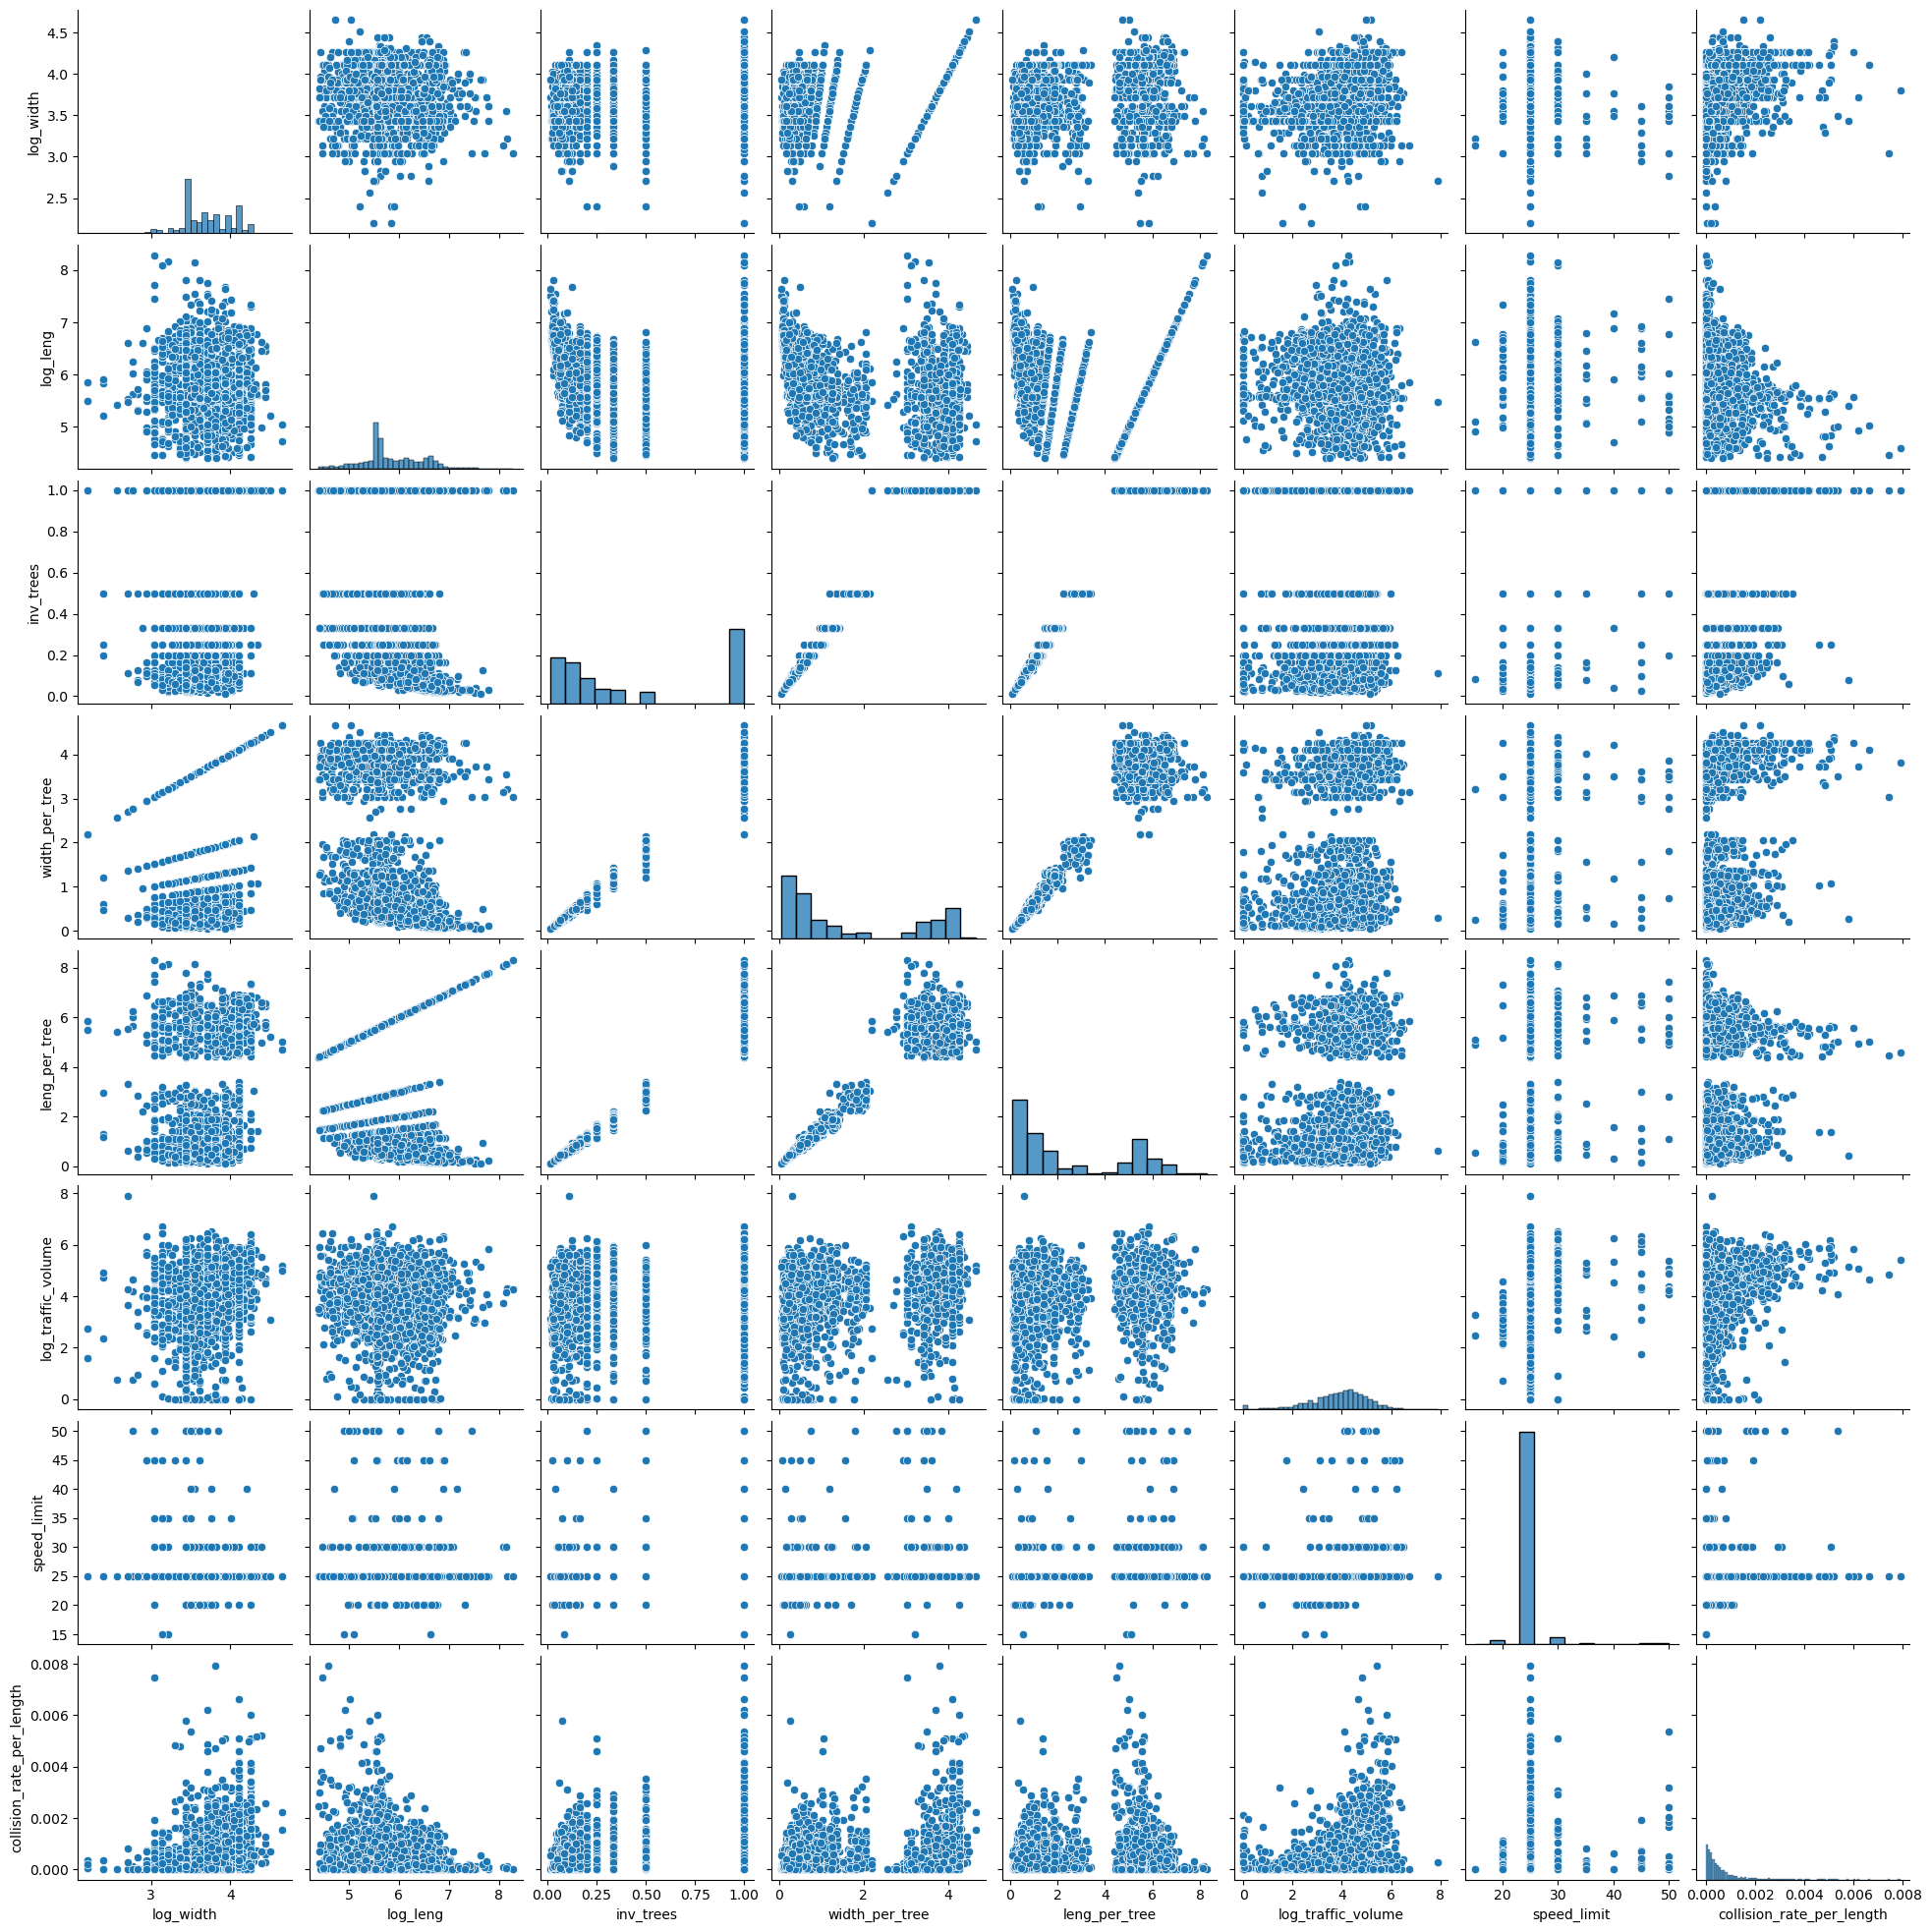

In [64]:
import seaborn as sns

cont_features = [
    "log_width",
    "log_leng",
    "inv_trees",
    "width_per_tree",
    "leng_per_tree",
    "log_traffic_volume",
    "speed_limit",
]
sns.pairplot(collisions_train_extra[cont_features + ["collision_rate_per_length"]])

In [65]:
linear_reg_features = [
    "log_width",
    "log_leng",
    "has_humps",
    "has_bike_lane",
    "is_av",
    "is_st",
    "is_rd",
    "inv_trees",
    "log_traffic_volume",
    "speed_limit",
]

In [66]:
collisions_train_extra[linear_reg_features].corr()

,log_width,log_leng,has_humps,has_bike_lane,is_av,is_st,is_rd,inv_trees,log_traffic_volume,speed_limit
log_width,1.000000,-0.073680,-0.125988,0.182373,0.201446,-0.144718,0.011103,0.254618,0.246455,-0.096145
log_leng,-0.073680,1.000000,0.138090,-0.027229,-0.182257,0.197279,0.003953,-0.271714,-0.112155,0.001109
has_humps,-0.125988,0.138090,1.000000,-0.010023,-0.072101,0.112662,-0.033111,-0.154798,-0.135029,-0.070582
has_bike_lane,0.182373,-0.027229,-0.010023,1.000000,0.041618,-0.002520,-0.021572,0.028936,0.054708,-0.043576
is_av,0.201446,-0.182257,-0.072101,0.041618,1.000000,-0.678053,-0.290090,0.123036,0.179319,0.009544
is_st,-0.144718,0.197279,0.112662,-0.002520,-0.678053,1.000000,-0.151052,-0.178990,-0.201665,-0.071964
is_rd,0.011103,0.003953,-0.033111,-0.021572,-0.290090,-0.151052,1.000000,0.032173,-0.005418,0.026970
inv_trees,0.254618,-0.271714,-0.154798,0.028936,0.123036,-0.178990,0.032173,1.000000,0.266132,0.141431
log_traffic_volume,0.246455,-0.112155,-0.135029,0.054708,0.179319,-0.201665,-0.005418,0.266132,1.000000,0.128460
speed_limit,-0.096145,0.001109,-0.070582,-0.043576,0.009544,-0.071964,0.026970,0.141431,0.128460,1.000000


In [67]:
X_train = collisions_train.drop(
    columns=["collision_rate_per_length", "collision_rate", "has_volume_meas"]
)
y_train = collisions_train["collision_rate_per_length"]

### Baseline model

In [68]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy="mean")

In [69]:
from sklearn.model_selection import cross_val_score

dummy_reg_scores = cross_val_score(
    dummy_reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)

In [70]:
-dummy_reg_scores.mean()

6.21789071861058e-07

In [71]:
dummy_reg.fit(X_train, y_train)

DummyRegressor()

In [72]:
import pickle
import os

os.makedirs("../models/regression", exist_ok=True)

with open("../models/regression/baseline.pkl", "wb") as f:
    pickle.dump(dummy_reg, f)

### Linear regression

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

lin_reg_transformations = ColumnTransformer(
    [
        ("log", LogarithmTransfomer(), ["st_width", "shape_leng", "traffic_volume"]),
        ("inv", InverseTransformer(), ["n_trees"]),
    ],
    remainder="passthrough",
)

lin_reg_pipeline = Pipeline(
    [
        ("column_transf", lin_reg_transformations),
        ("std_scaler", StandardScaler()),
        ("linear_reg", LinearRegression()),
    ]
)

In [74]:
def get_column_names(transformed_columns: list[str] | np.ndarray) -> list[str]:
    return list(map(lambda o: o.split("__")[1], transformed_columns))

In [75]:
y_train.describe()

count    2537.000000
mean        0.000612
std         0.000788
min         0.000000
25%         0.000152
50%         0.000356
75%         0.000748
max         0.007908
Name: collision_rate_per_length, dtype: float64

In [76]:
base_lin_reg_score = cross_val_score(
    lin_reg_pipeline, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)

In [77]:
-base_lin_reg_score.mean()

4.7129491486675766e-07

In [78]:
lin_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log', LogarithmTransfomer(),
                                                  ['st_width', 'shape_leng',
                                                   'traffic_volume']),
                                                 ('inv', InverseTransformer(),
                                                  ['n_trees'])])),
                ('std_scaler', StandardScaler()),
                ('linear_reg', LinearRegression())])

In [79]:
coefficients = pd.DataFrame(
    lin_reg_pipeline["linear_reg"].coef_,
    index=get_column_names(lin_reg_pipeline["column_transf"].get_feature_names_out()),
    columns=["coefficient"],
).sort_values(by="coefficient", key=abs, ascending=False)

In [80]:
coefficients

,coefficient
log_traffic_volume,0.000170
log_st_width,0.000165
log_shape_leng,-0.000161
inv_n_trees,0.000108
is_st,0.000089
n_parking_meters,0.000083
is_av,0.000051
speed_limit,0.000019
has_bike_lane,0.000016
is_rd,-0.000013


In [81]:
with open("../models/regression/base_linear.pkl", "wb") as f:
    pickle.dump(lin_reg_pipeline, f)

In [82]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso


def get_scores_for_lasso(
    X_train, y_train, n_features: int, min_alpha=0.001, max_alpha=1
):
    alphas = np.linspace(min_alpha, max_alpha, 300)

    data_array = np.zeros(shape=(300, n_features + 5))

    for i, alpha in enumerate(alphas):

        lasso_pipeline = Pipeline(
            [
                ("column_transf", lin_reg_transformations),
                ("std_scaler", StandardScaler()),
                ("lasso", Lasso(alpha=alpha, max_iter=10_000)),
            ]
        )
        lasso_scores = cross_val_score(
            lasso_pipeline, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
        )
        lasso_r2_scores = cross_val_score(
            lasso_pipeline, X_train, y_train, cv=5, scoring="r2"
        )
        val_r2 = lasso_r2_scores.mean()
        val_mse = -lasso_scores.mean()
        lasso_pipeline.fit(X_train, y_train)
        y_pred = lasso_pipeline.predict(X_train)
        train_mse = mean_squared_error(y_train, y_pred)
        train_r2 = r2_score(y_train, y_pred)
        data_array[i, 0] = alpha
        data_array[i, -4] = train_r2
        data_array[i, -3] = val_r2
        data_array[i, -2] = train_mse
        data_array[i, -1] = val_mse
        data_array[i, 1:-4] = lasso_pipeline["lasso"].coef_
    features = get_column_names(lasso_pipeline["column_transf"].get_feature_names_out())
    columns = ["alpha"] + features + ["train_r2", "val_r2", "train_mse", "val_mse"]
    return pd.DataFrame(data_array, columns=columns)

In [83]:
lasso_scores = get_scores_for_lasso(
    X_train, y_train, 11, min_alpha=0.00000000001, max_alpha=0.00001
)

In [84]:
lasso_scores.head(10)

,alpha,log_st_width,log_shape_leng,log_traffic_volume,inv_n_trees,has_bike_lane,is_av,is_st,is_rd,has_humps,speed_limit,n_parking_meters,train_r2,val_r2,train_mse,val_mse
0,1.000000e-11,0.000165,-0.000161,0.00017,0.000108,0.000016,0.000051,0.000089,-0.000013,-0.000008,0.000019,0.000083,0.249147,0.241116,4.664682e-07,4.712949e-07
1,3.345478e-08,0.000165,-0.000161,0.00017,0.000108,0.000016,0.000051,0.000089,-0.000013,-0.000008,0.000019,0.000083,0.249147,0.241116,4.664682e-07,4.712945e-07
2,6.689957e-08,0.000165,-0.000161,0.00017,0.000108,0.000016,0.000050,0.000089,-0.000013,-0.000008,0.000019,0.000083,0.249146,0.241117,4.664683e-07,4.712941e-07
3,1.003443e-07,0.000165,-0.000161,0.00017,0.000108,0.000016,0.000050,0.000089,-0.000013,-0.000008,0.000019,0.000083,0.249146,0.241117,4.664683e-07,4.712938e-07
4,1.337891e-07,0.000165,-0.000161,0.00017,0.000108,0.000016,0.000050,0.000088,-0.000013,-0.000008,0.000019,0.000083,0.249146,0.241117,4.664684e-07,4.712935e-07
5,1.672339e-07,0.000165,-0.000161,0.00017,0.000108,0.000016,0.000050,0.000088,-0.000013,-0.000008,0.000019,0.000083,0.249146,0.241117,4.664686e-07,4.712932e-07
6,2.006787e-07,0.000165,-0.000161,0.00017,0.000108,0.000016,0.000050,0.000088,-0.000013,-0.000007,0.000019,0.000083,0.249146,0.241118,4.664687e-07,4.712929e-07
7,2.341235e-07,0.000165,-0.000161,0.00017,0.000108,0.000016,0.000050,0.000088,-0.000013,-0.000007,0.000019,0.000083,0.249145,0.241118,4.664689e-07,4.712926e-07
8,2.675683e-07,0.000165,-0.000161,0.00017,0.000108,0.000016,0.000050,0.000088,-0.000013,-0.000007,0.000019,0.000083,0.249145,0.241118,4.664691e-07,4.712924e-07
9,3.010130e-07,0.000165,-0.000161,0.00017,0.000108,0.000016,0.000050,0.000088,-0.000013,-0.000007,0.000019,0.000083,0.249145,0.241118,4.664693e-07,4.712923e-07


In [85]:
lasso_scores.iloc[np.argmin(lasso_scores.val_mse.values)]

alpha                 2.976596e-06
log_st_width          1.642742e-04
log_shape_leng       -1.585834e-04
log_traffic_volume    1.684809e-04
inv_n_trees           1.065518e-04
has_bike_lane         1.407193e-05
is_av                 4.098862e-05
is_st                 7.756205e-05
is_rd                -1.432357e-05
has_humps            -5.473121e-06
speed_limit           1.578541e-05
n_parking_meters      8.097930e-05
train_r2              2.489702e-01
val_r2                2.411300e-01
train_mse             4.665778e-07
val_mse               4.712751e-07
Name: 89, dtype: float64

Text(0.0, 1.0, 'Train and validation MSE against Lasso alpha')

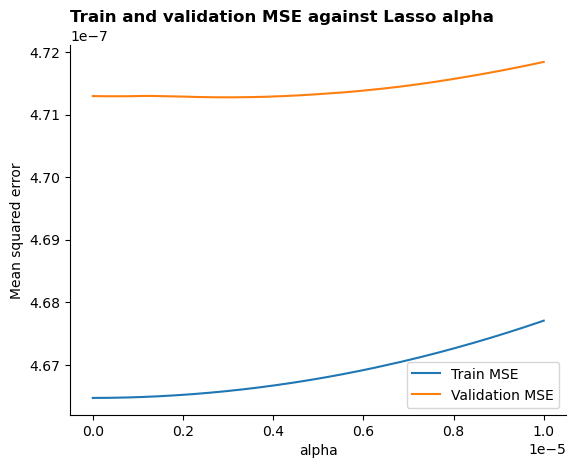

In [86]:
plt.plot(lasso_scores.alpha.values, lasso_scores.train_mse.values, label="Train MSE")
plt.plot(lasso_scores.alpha.values, lasso_scores.val_mse.values, label="Validation MSE")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.legend()
plt.title("Train and validation MSE against Lasso alpha")

### Linear regression with quadratic features

In [87]:
from sklearn.preprocessing import PolynomialFeatures

quad_reg_pipeline = Pipeline(
    [
        ("column_transf", lin_reg_transformations),
        ("quad_feats", PolynomialFeatures(degree=2, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("linear_reg", LinearRegression()),
    ]
)

In [88]:
quadratic_features_mse = cross_val_score(
    quad_reg_pipeline, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)

In [89]:
-quadratic_features_mse.mean()

4.403153129694504e-07

In [90]:
quad_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log', LogarithmTransfomer(),
                                                  ['st_width', 'shape_leng',
                                                   'traffic_volume']),
                                                 ('inv', InverseTransformer(),
                                                  ['n_trees'])])),
                ('quad_feats', PolynomialFeatures(include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('linear_reg', LinearRegression())])

### K-Nearest Neighbors

In [91]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn_transformation = ColumnTransformer(
    [("log", LogarithmTransfomer(), ["st_width", "shape_leng", "traffic_volume"])]
)

knn_pipeline = Pipeline(
    [
        ("column_transf", knn_transformation),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor()),
    ]
)

knn_grid = {
    "knn__n_neighbors": range(5, 500, 10),
    "knn__weights": ["uniform", "distance"],
}

knn_search = GridSearchCV(
    knn_pipeline,
    param_grid=knn_grid,
    cv=5,
    return_train_score=True,
    scoring="neg_mean_squared_error",
)

In [92]:
knn_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transf',
                                        ColumnTransformer(transformers=[('log',
                                                                         LogarithmTransfomer(),
                                                                         ['st_width',
                                                                          'shape_leng',
                                                                          'traffic_volume'])])),
                                       ('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': range(5, 500, 10),
                         'knn__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [93]:
knn_search.best_score_

-4.4565709000469025e-07

In [94]:
uniform_scores = []
uniform_n_neighbors = []
distance_scores = []
distance_n_neighbors = []

for param, score in zip(
    knn_search.cv_results_["params"], knn_search.cv_results_["mean_test_score"]
):
    if param["knn__weights"] == "uniform":
        uniform_scores.append(-score)
        uniform_n_neighbors.append(param["knn__n_neighbors"])
    else:
        distance_scores.append(-score)
        distance_n_neighbors.append(param["knn__n_neighbors"])

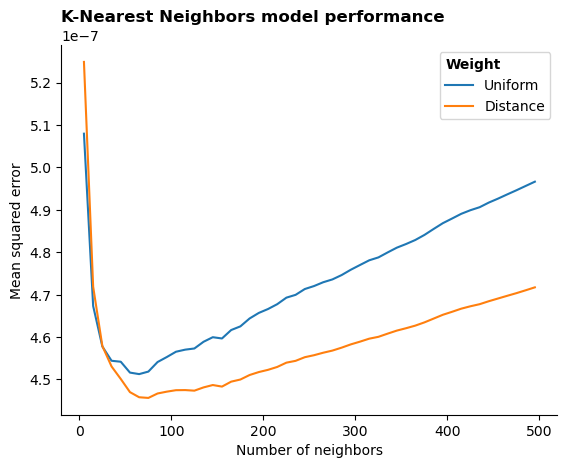

In [95]:
plt.plot(uniform_n_neighbors, uniform_scores, label="Uniform")
plt.plot(distance_n_neighbors, distance_scores, label="Distance")
plt.title("K-Nearest Neighbors model performance")
plt.ylabel("Mean squared error")
plt.xlabel("Number of neighbors")
leg = plt.legend(title="Weight", title_fontproperties={"weight": "bold"})
leg._legend_box.align = "left"

In [96]:
knn_search.best_params_

{'knn__n_neighbors': 75, 'knn__weights': 'distance'}

In [97]:
with open("../models/regression/knn.pkl", "wb") as f:
    pickle.dump(knn_search.best_estimator_, f)

### Random forests

In [98]:
from sklearn.ensemble import RandomForestRegressor

grid = {
    "n_estimators": [50, 100, 500],
    "min_samples_split": [10, 20, 50],
}

grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid=grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    return_train_score=True,
)

In [99]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_split': [10, 20, 50],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [100]:
-grid_search.best_score_

4.3412851003764196e-07

In [101]:
grid_search.best_estimator_

RandomForestRegressor(min_samples_split=50, n_estimators=50)

In [102]:
with open("../models/regression/random_forest.pkl", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

### XGBoost

In [103]:
from xgboost import XGBRegressor

In [104]:
xgb_grid = {
    "n_estimators": [400, 500, 800, 1000],
    "max_depth": [1, 5, 10, 20],
    "learning_rate": [0.1, 0.05, 0.01, 0.001, 0.0001],
}

xgb_search = GridSearchCV(
    XGBRegressor(),
    param_grid=xgb_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    return_train_score=True,
)

In [105]:
xgb_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01, 0.001, 0.0001],
                         'max_depth': [1, 5, 10, 20],
                         'n_estimators': [400, 500, 800, 1000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [106]:
xgb_search.best_score_

-4.2755620241127286e-07

In [107]:
with open("../models/regression/xgboost.pkl", "wb") as f:
    pickle.dump(xgb_search.best_estimator_, f)

### XGBoost analysis

In [108]:
feature_importances = pd.DataFrame(
    xgb_search.best_estimator_.feature_importances_,
    index=xgb_search.feature_names_in_,
    columns=["importance"],
).sort_values(by="importance", ascending=False)

In [109]:
feature_importances

,importance
traffic_volume,0.215916
st_width,0.156561
shape_leng,0.107038
is_st,0.103386
n_trees,0.084745
is_av,0.076215
speed_limit,0.066040
has_bike_lane,0.062024
n_parking_meters,0.060107
is_rd,0.043010


Text(0.5, 0, 'Importance')

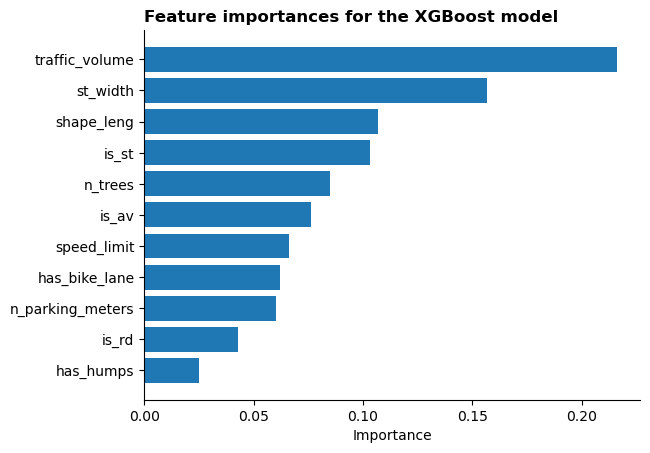

In [110]:
_, ax = plt.subplots()

ax.barh(feature_importances.index, feature_importances.importance)
ax.invert_yaxis()
ax.set_title("Feature importances for the XGBoost model")
ax.set_xlabel("Importance")

Text(0, 0.5, 'Residuals')

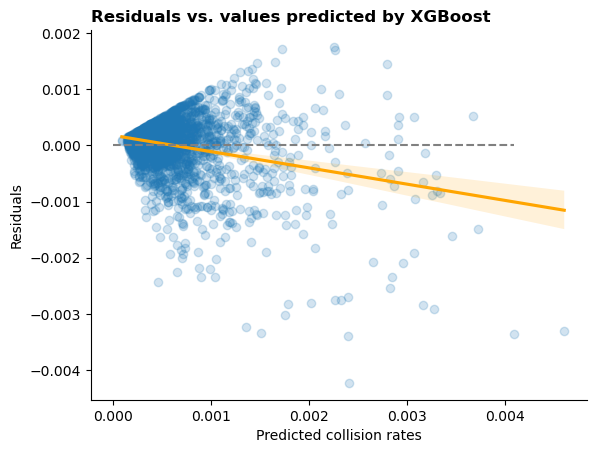

In [111]:
y_pred = xgb_search.best_estimator_.predict(X_train)
residuals = y_pred - y_train
sns.regplot(
    x=y_pred, y=residuals, line_kws={"color": "orange"}, scatter_kws={"alpha": 0.2}
)
plt.plot([0, 0.0041], [0, 0], color="grey", linestyle="dashed")
plt.title("Residuals vs. values predicted by XGBoost")
plt.xlabel("Predicted collision rates")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

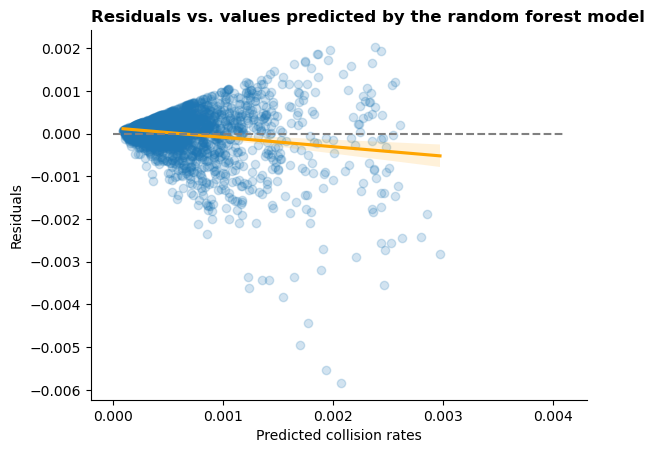

In [112]:
y_pred = grid_search.best_estimator_.predict(X_train)
residuals = y_pred - y_train
sns.regplot(
    x=y_pred, y=residuals, line_kws={"color": "orange"}, scatter_kws={"alpha": 0.2}
)
plt.plot([0, 0.0041], [0, 0], color="grey", linestyle="dashed")
plt.title("Residuals vs. values predicted by the random forest model")
plt.xlabel("Predicted collision rates")
plt.ylabel("Residuals")